In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward_OIB
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO
# from prepare_inputs_OE_sevlayer import prepare_inputs_sevlayer

In [2]:
FYI_data = piO.OIB_data('FYI')
FYI_data.TbV_AMSR_all
FYI_data.TbH_AMSR_all

FYI_OIB_AMSR = np.concatenate([[TbV, TbH] for TbV, TbH in zip(FYI_data.TbV_AMSR_all, FYI_data.TbH_AMSR_all)])

FYI_OIB_SIM = np.concatenate([np.mean(FYI_data.TbV_sim, axis=0), np.mean(FYI_data.TbH_sim, axis=0)])
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])

FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])


FYI_bias = FYI_OIB_SIM - FYI_OIB_AMSR
FYI_bias
# FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_sim, axis=0), np.std(FYI_data.TbH_sim, axis=0)])

array([ 2.98118478,  1.97006502,  3.41070605,  5.0414478 , 10.88125259,
        0.33587901,  1.77948448,  8.26962343, 10.04427615, 16.76142638])

### Check prior information
OE requires that the distribution of the prior data follow a normal distribution. This is checked:

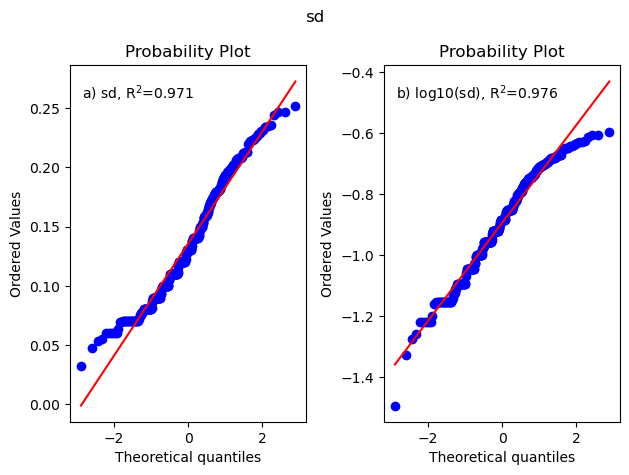

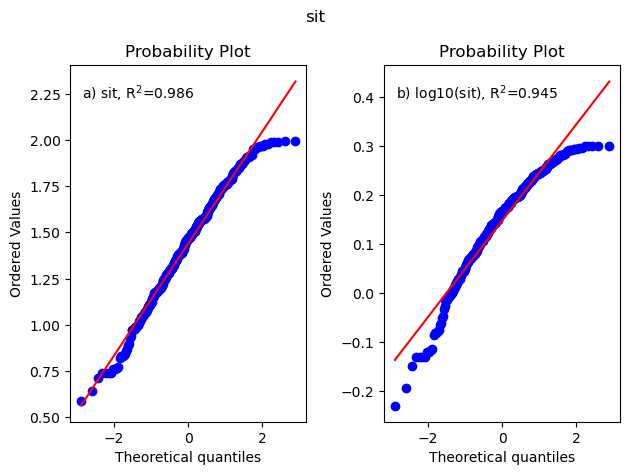

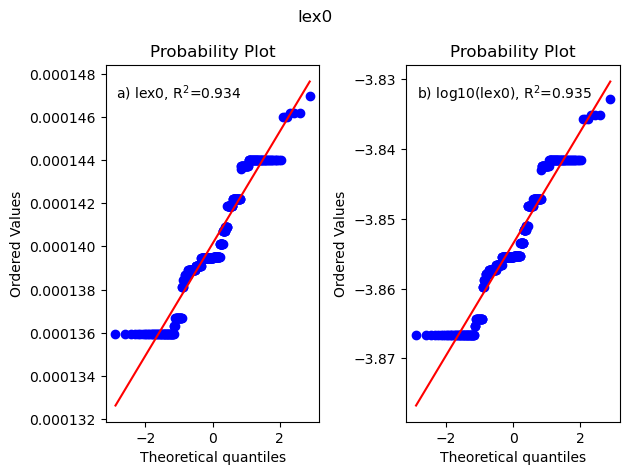

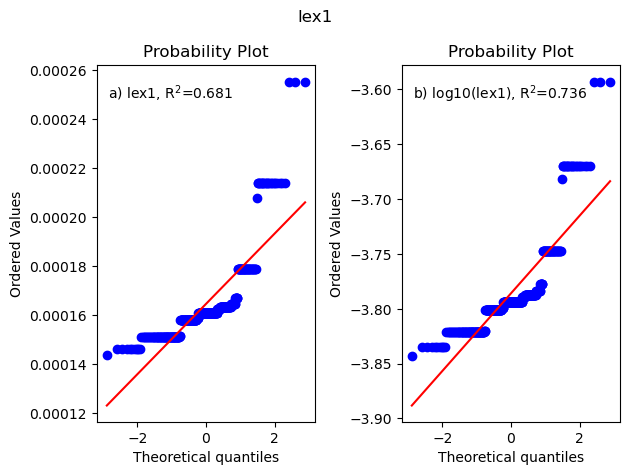

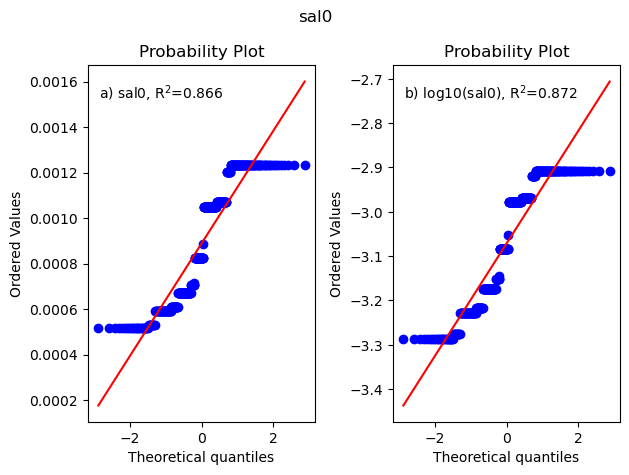

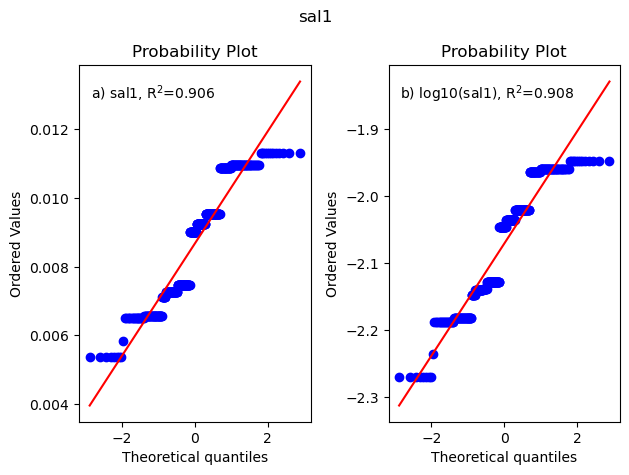

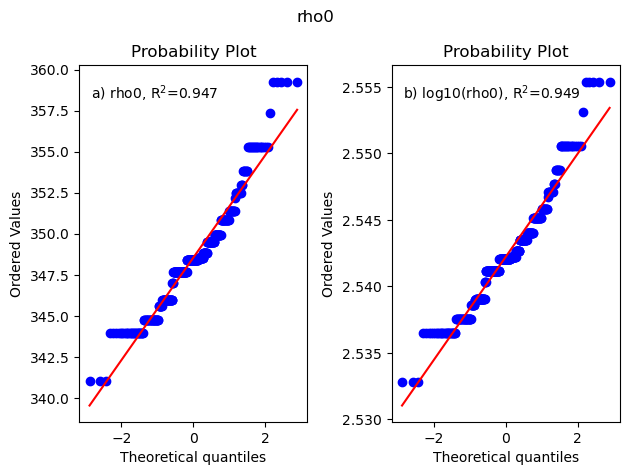

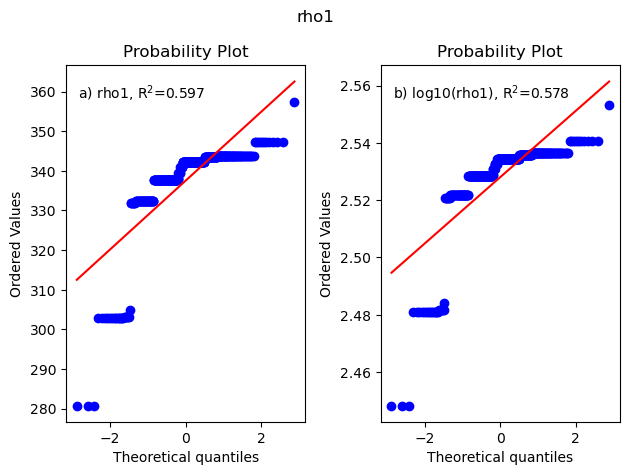

In [7]:
sd = np.sum(FYI_data.sd, axis=1)
for var,varname in zip([sd, FYI_data.sit, FYI_data.sd_lex[:,0], FYI_data.sd_lex[:,1],
                        FYI_data.sd_sal[:,0], FYI_data.sd_sal[:,1], 
                        FYI_data.sd_rho[:,0], FYI_data.sd_rho[:,1]], ['sd', 'sit', 'lex0', 'lex1', 'sal0', 'sal1','rho0', 'rho1']):
        fig, (ax, ax1) = plt.subplots(ncols=2)
        plt.suptitle('%s' % (varname))
        (osm, osr), (slope, intercept, r) = stats.probplot(
            var,
            dist="norm",
            plot=ax,
            fit=True,
            rvalue=False)
        ax.text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % ('a', varname, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            np.log10(var),
            dist="norm",
            plot=ax1,
            fit=True,
            rvalue=False)
        ax1.text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % ('b', 'log10(%s)'%varname, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax1.transAxes)
        fig.tight_layout()
        plt.savefig('C:/Users/Ida Olsen/Documents/Speciale_2022/figures/reference_results/log_plots' + varname+ '.png')

In [4]:
## Define name of y-variables
y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"] 
# Define values
y_obs  = FYI_OIB_AMSR
## covariance matrix for TBs - 10X10 matrix
# y_cov = np.diag([4,4,4,4,4,4,4,4,4,4])# np.diag(FYI_OIB_AMSR_std)*2
y_cov = np.diag([0.4]*5 + [2.0]*5)# np.diag(FYI_OIB_AMSR_std)*2


# Define name of x-variables
x_vars = ["SD", "lex", "sal", "SIT", "slope"]
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(x_vars)

# print first guess info
print(x_info)
# print lower limit (unit m)
print(x_lowerLimit)
# print upper limit (unit m)
print(x_upperLimit)

{'SD0 cm': 12.07, 'SD1 cm': 3.0, 'lex mm': 0.5, 'sal PSU': 8.67, 'SIT cm': 143.98281690140846, 'slope': 0.07880041306108115}
{'SD0': 0.0, 'SD1': 0.0, 'lex': 1e-05, 'sal': 1e-06, 'SIT': 0.0, 'slope': 0}
{'SD0': 1.0, 'SD1': 1.0, 'lex': 0.0009, 'sal': 0.02, 'SIT': 5.0, 'slope': 1.0}


## Plot Uncertainties

(6, 6)
(6,)


Text(0.5, 1.0, 'input uncertainty $\\mathbf{S}_{a}$')

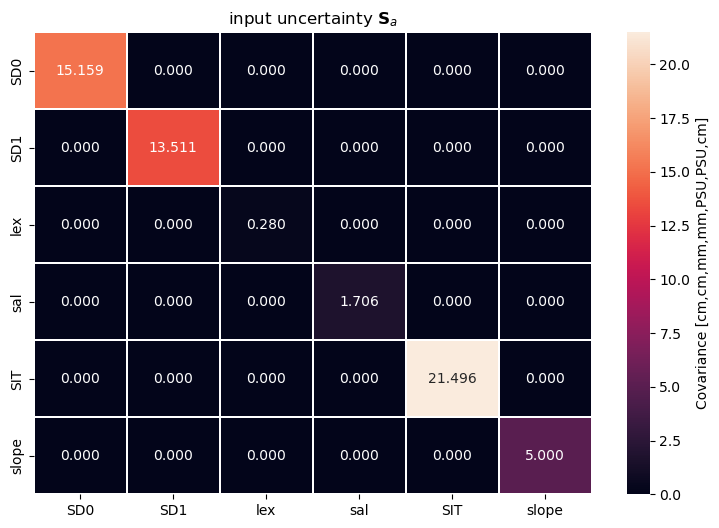

In [5]:
x_cov[0,0] = x_cov[0,0]*10
x_cov[1,1] = x_cov[1,1]*10**(0.9)
x_cov[2,2] = x_cov[2,2]*100
x_cov[3,3] = x_cov[3,3]
x_cov[4,4] = x_cov[4,4]/2
x_cov[5,5] = 0.05**2
try: # if OE on Tsur
    x_cov[7,7] = x_cov[7,7]
except:
    pass
d = np.diag(x_cov)
x_cov = np.diag(d)
print(x_cov.shape)
print(x_ap.shape)

nl_snow = 2
x_vars = list(x_upperLimit.keys())

forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow}
oe_show = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,convergenceFactor=10
        )

oe_show.S_a = oe_show.S_a**(1/2)
oe_show.S_a['lex']['lex'] = oe_show.S_a['lex']['lex']*1e1
oe_show.S_a['sal']['sal'] = oe_show.S_a['sal']['sal']*1e1
# oe_show.S_a['lex0']['lex0'] = oe_show.S_a['lex0']['lex0']*1e1
# oe_show.S_a['lex1']['lex1'] = oe_show.S_a['lex1']['lex1']*1e1
try:
    oe_show.S_a['sal0']['sal0'] = oe_show.S_a['sal0']['sal0']*1e1
    oe_show.S_a['sal1']['sal1'] = oe_show.S_a['sal1']['sal1']*1e1
except:
    pass
try:
    oe_show.S_a['Tsur']['Tsur'] = oe_show.S_a['Tsur']['Tsur']/1e2
except:
    pass
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    oe_show.S_a*1e2,
    annot=True, 
    fmt='.3f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [cm,cm,mm,mm,PSU,PSU,cm]'}
)
ax.set_title(r'input uncertainty $\mathbf{S}_{a}$')

Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$')

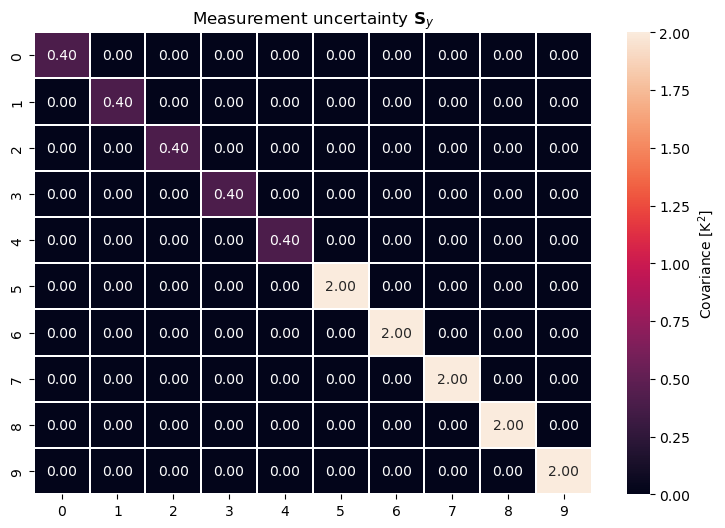

In [6]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    y_cov, 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$')

In [7]:
## define extra arguments to forward function
nl_snow=2
x_vars = list(x_upperLimit.keys())
print(x_vars)
print(y_vars)
forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n": 0, "avg":True}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,convergenceFactor=10
        )
print(x_info)

['SD0', 'SD1', 'lex', 'sal', 'SIT', 'slope']
['6V', '10V', '18V', '23V', '36V', '6H', '10H', '18H', '23H', '36H']
{'SD0 cm': 12.07, 'SD1 cm': 3.0, 'lex mm': 0.5, 'sal PSU': 8.67, 'SIT cm': 143.98281690140846, 'slope': 0.07880041306108115}


In [8]:
# run the optimization and print outputs
oe.doRetrieval(maxIter=10)

############################################################
reset due to x_upperLimit: lex from 0.001105 to 0.000500 in iteration 0
1.80 s, iteration 1, degrees of freedom: 3.75 of 6, not converged (x-space):  34.766
2.57 s, iteration 2, degrees of freedom: 3.42 of 6, not converged (x-space):  59.060
3.28 s, iteration 3, degrees of freedom: 3.64 of 6, not converged (x-space):  17.415
3.98 s, iteration 4, degrees of freedom: 3.59 of 6, not converged (x-space):  1.902
4.74 s, iteration 5, degrees of freedom: 3.62 of 6, not converged (x-space):  2.279
5.46 s, iteration 6, degrees of freedom: 3.66 of 6, not converged (x-space):  0.910
6.18 s, iteration 7, degrees of freedom: 3.61 of 6, converged (x-space):  0.379
6.91 s, iteration 8, degrees of freedom: 3.66 of 6, done.  0.624


True

In [9]:
print('----------------')
print('OE values')
print(oe.x_op[0] + oe.x_op[1])
print(oe.x_op[1])
print(oe.x_op[2]*1e3)
print(oe.x_op[3]*1e3)
print(oe.x_op[4])
# print(oe.x_op[5]*1e3)
try:
    print(oe.x_op[6])
except:
    pass
# print(oe.x_op)

print('----------------')
print('First guess')
print(x_ap[0] + x_ap[1])
print(x_ap[2]*1e3)
print(x_ap[3]*1e3)
print(x_ap[4])
# print(x_ap[5]*1e3)
# print(x_ap[6])

print('----------------')
print('AVERAGE VALUES')
print(np.mean(np.sum(FYI_data.sd, axis=1)))
print(np.mean(FYI_data.sd_lex)*1e3)
print(np.mean(FYI_data.sd_sal)*1e3)
print(np.mean(FYI_data.sit))
print(np.mean(FYI_data.skt))

----------------
OE values
0.09218460323897833
0.06963443364136711
0.7015183638280765
4.822395661998043
1.3790811776870708
----------------
First guess
0.15067323943661964
0.5
8.673198380864122
1.4398281690140846
----------------
AVERAGE VALUES
0.15067323943661973
0.23352233987484197
4.7806093518220765
1.4398281690140846
253.0837746478873


In [10]:
oe.summary()
# oe.plotIterations()

<xarray.Dataset>
Dimensions:             (x_vars: 6, x_vars_T: 6, y_vars: 10, y_vars_T: 10)
Coordinates:
  * x_vars              (x_vars) object 'SD0' 'SD1' 'lex' 'sal' 'SIT' 'slope'
  * x_vars_T            (x_vars_T) object 'SD0' 'SD1' 'lex' 'sal' 'SIT' 'slope'
  * y_vars              (y_vars) object '6V' '10V' '18V' ... '18H' '23H' '36H'
  * y_vars_T            (y_vars_T) object '6V' '10V' '18V' ... '18H' '23H' '36H'
Data variables: (12/13)
    x_a                 (x_vars) float64 0.1207 0.03 0.0005 0.008673 1.44 0.0788
    x_a_err             (x_vars) float64 0.1516 0.1351 0.0002797 ... 0.215 0.05
    S_a                 (x_vars, x_vars_T) float64 0.02298 0.0 ... 0.0 0.0025
    x_op                (x_vars) float64 0.02255 0.06963 ... 1.379 0.06742
    x_op_err            (x_vars) float64 0.04393 0.02756 ... 0.2108 0.03547
    S_op                (x_vars, x_vars_T) float64 0.00193 -0.00112 ... 0.001258
    ...                  ...
    y_obs               (y_vars) float64 253.5 254.9 254.0 ... 234.6 235.3 229.9
    S_y                 (y_vars, y_vars_T) float64 0.4 0.0 0.0 ... 0.0 0.0 2.0
    y_op                (y_vars) float64 253.3 254.8 253.6 ... 235.6 236.2 231.3
    x_truth             (x_vars) float64 nan nan nan nan nan nan
    dgf                 float64 3.656
    convergedIteration  int32 8

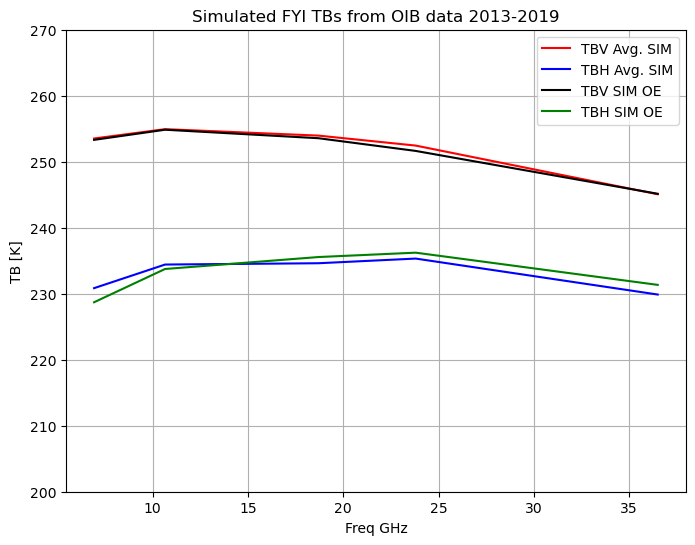

In [11]:
## Plots results
# res_start = forward_OIB([], [], nl_snow)
res = oe.y_op

plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

# FYI_OIB_AMSR = FYI_OIB_AMSR + FYI_bias
y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. SIM')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. SIM')
y = res[:5]
plt.plot(freqs, y, c='k', label = 'TBV SIM OE')
y = res[5:]
plt.plot(freqs, y, c='green', label = 'TBH SIM OE')
# y = res_start[:5]
# plt.plot(freqs, y, c='orange', label = 'TBV SIM start')
# y = res_start[5:]
# plt.plot(freqs, y, c='magenta', label = 'TBH SIM start')
plt.grid()
plt.ylim([200,270])
# plt.legend(['TBV', 'TBH', 'TBV AMSR', 'TBH AMSR'])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

In [12]:
b = oe.y_op-FYI_OIB_AMSR
print(b)
## Make chi2test to see if hypothesees are adequate
chiSquareTest = oe.chiSquareTest(significance=0.10)
print('\nTests passed:\n' ,chiSquareTest[0])

6V    -0.207250
10V   -0.088164
18V   -0.396468
23V   -0.809258
36V    0.073611
6H    -2.135750
10H   -0.673520
18H    0.939081
23H    0.894739
36H    1.464849
dtype: float64
Warning. Singular Matrix with rank 6 instead of 10. (This is typically save to ignore)       
Warning. Singular Matrix with rank 4 instead of 6. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool


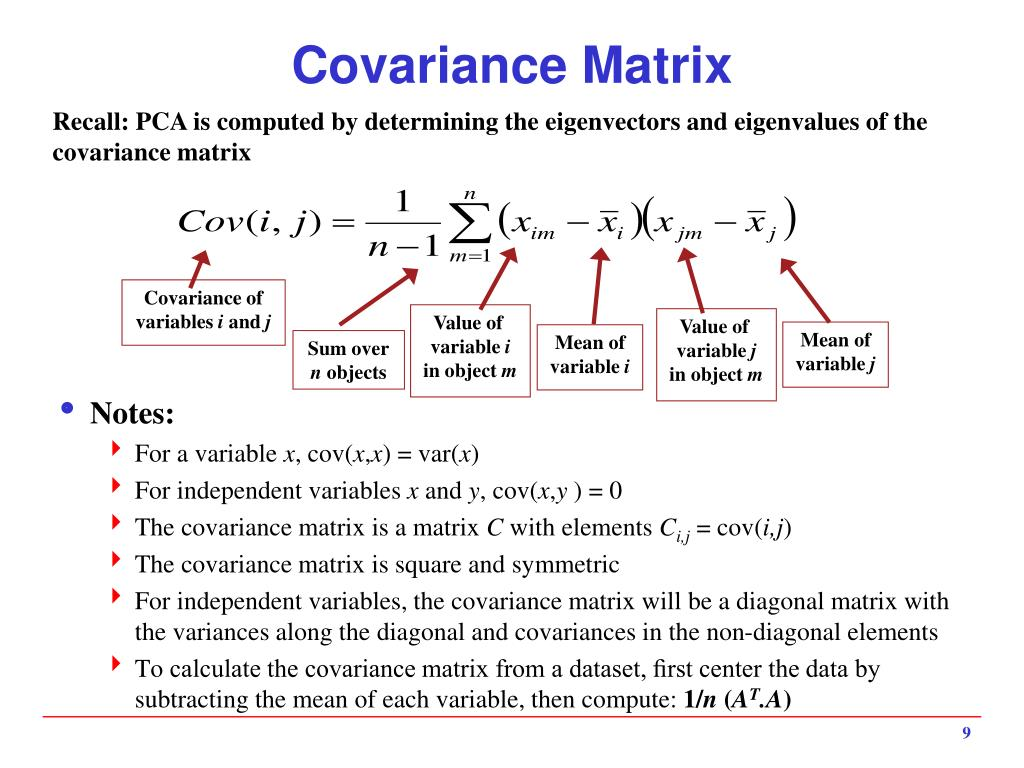

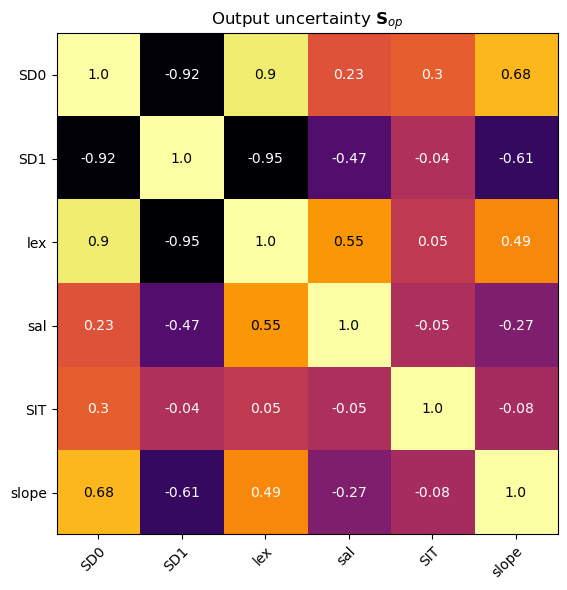

In [13]:
#def corrMat(data):
corrMat = np.zeros(oe.S_op.shape)
sigmas = np.diag(oe.S_op)**(1/2)
rows = range(oe.S_op.shape[0])
cols = range(oe.S_op.shape[1])
for row in rows:
    sigma1 = sigmas[row]
    for col in cols:
        sigma2 = sigmas[col]
        
        corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)

        
        
 
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(corrMat, cmap="inferno")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(oe.S_op.keys())):
    for j in range(len(oe.S_op.keys())):
        if np.round(corrMat[i, j],2) > 0.5:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                   ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                           ha="center", va="center", color="w")

ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


fig.tight_layout()
plt.show()

![image.png](attachment:image.png)

Text(0.5, 1.0, 'Output uncertainty $\\mathbf{S}_{op}$')

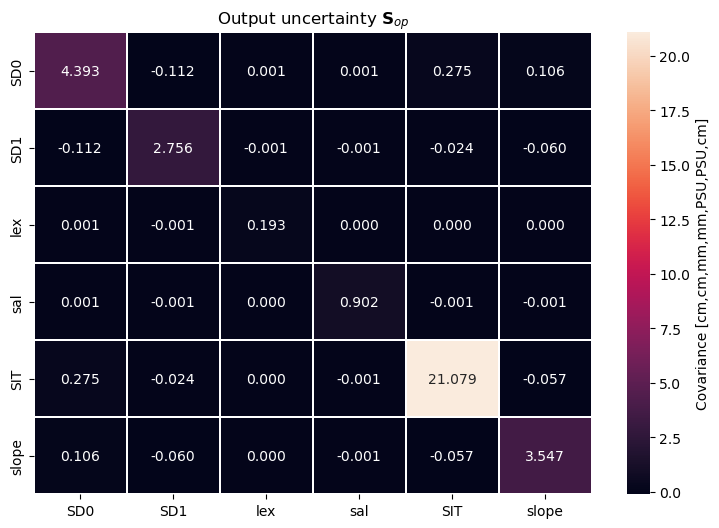

In [14]:
oe.S2 = oe.S_op.copy()
for d in oe.S_op.keys():# for key2 in oe.S_op.keys():
    oe.S2[d][d] = oe.S_op[d][d]**(1/2)
oe.S2['lex']['lex'] = oe.S2['lex']['lex']*1e1
oe.S2['sal']['sal'] = oe.S2['sal']['sal']*1e1
# oe_show.S_a['lex0']['lex0'] = oe_show.S_a['lex0']['lex0']*1e1
# oe_show.S_a['lex1']['lex1'] = oe_show.S_a['lex1']['lex1']*1e1
try:
    oe.S2['sal0']['sal0'] = oe.S_op['sal0']['sal0']*1e1
    oe.S2['sal1']['sal1'] = oe.S_op['sal1']['sal1']*1e1
except:
    pass
try:
    oe.S2['Tsur']['Tsur'] = oe.S_op['Tsur']['Tsur']/1e2
except:
    pass
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    oe.S2*1e2,
    annot=True, 
    fmt='.3f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [cm,cm,mm,mm,PSU,PSU,cm]'}
)
ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')

## OIB OE of individual measurements

In [15]:
# Define name of x-variables
x_vars = ["SD", "lex", "sal", "SIT", "slope"]
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(x_vars)

# x_cov[2,2] = 
# print first guess info
print(x_info)
l = [0.5]*5 + [2.0]*5
y_cov = np.diag(l)
## define extra arguments to forward function
nl_snow=2
x_vars = list(x_upperLimit.keys())
print(x_vars)
print(y_vars)
# forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow}

{'SD0 cm': 12.07, 'SD1 cm': 3.0, 'lex mm': 0.5, 'sal PSU': 8.67, 'SIT cm': 143.98281690140846, 'slope': 0.07880041306108115}
['SD0', 'SD1', 'lex', 'sal', 'SIT', 'slope']
['6V', '10V', '18V', '23V', '36V', '6H', '10H', '18H', '23H', '36H']


(6, 6)
(6,)


Text(0.5, 1.0, 'input uncertainty $\\mathbf{S}_{a}$')

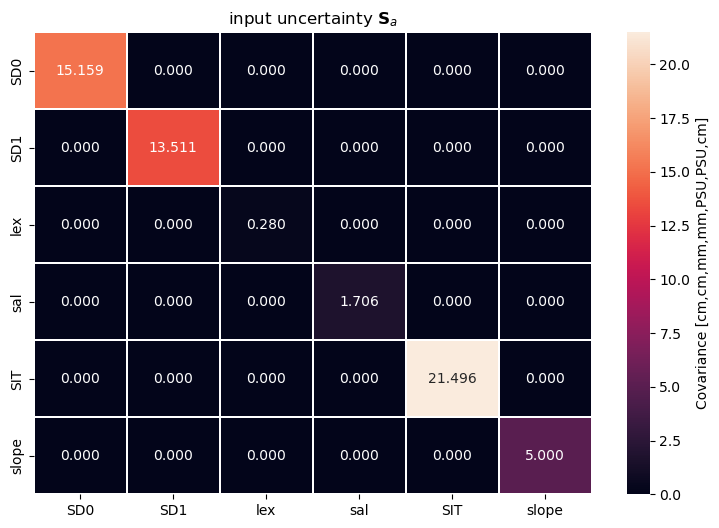

In [16]:
x_cov[0,0] = x_cov[0,0]*10
x_cov[1,1] = x_cov[1,1]*10**(0.9)
x_cov[2,2] = x_cov[2,2]*100
x_cov[3,3] = x_cov[3,3]
x_cov[4,4] = x_cov[4,4]/2
x_cov[5,5] = 0.05**2
try: # if OE on Tsur
    x_cov[7,7] = x_cov[7,7]
except:
    pass
d = np.diag(x_cov)
x_cov = np.diag(d)
print(x_cov.shape)
print(x_ap.shape)

nl_snow = 2
x_vars = list(x_upperLimit.keys())

forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow}
oe_show = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,convergenceFactor=10
        )

oe_show.S_a = oe_show.S_a**(1/2)
oe_show.S_a['lex']['lex'] = oe_show.S_a['lex']['lex']*1e1
oe_show.S_a['sal']['sal'] = oe_show.S_a['sal']['sal']*1e1
# oe_show.S_a['lex0']['lex0'] = oe_show.S_a['lex0']['lex0']*1e1
# oe_show.S_a['lex1']['lex1'] = oe_show.S_a['lex1']['lex1']*1e1
try:
    oe_show.S_a['sal0']['sal0'] = oe_show.S_a['sal0']['sal0']*1e1
    oe_show.S_a['sal1']['sal1'] = oe_show.S_a['sal1']['sal1']*1e1
except:
    pass
try:
    oe_show.S_a['Tsur']['Tsur'] = oe_show.S_a['Tsur']['Tsur']/1e2
except:
    pass
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    oe_show.S_a*1e2,
    annot=True, 
    fmt='.3f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [cm,cm,mm,mm,PSU,PSU,cm]'}
)
ax.set_title(r'input uncertainty $\mathbf{S}_{a}$')

Text(0.5, 1.0, 'Output uncertainty $\\mathbf{S}_{op}$')

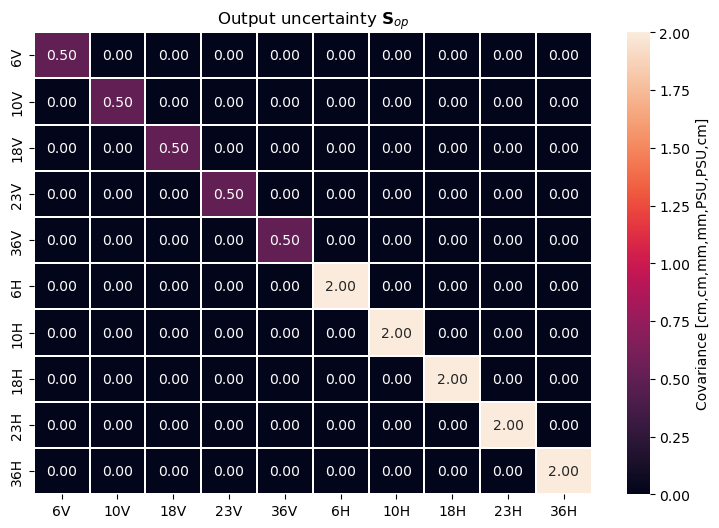

In [17]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    oe_show.S_y,
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [cm,cm,mm,mm,PSU,PSU,cm]'}
)
ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')

range(1, 20)


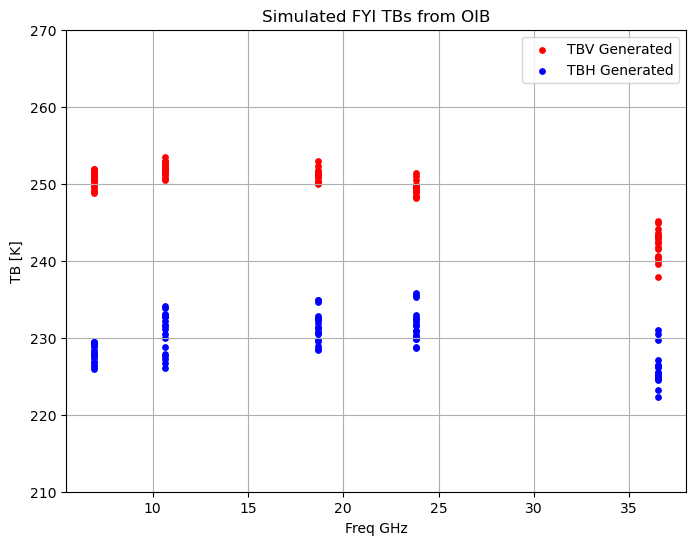

range(2, 30)


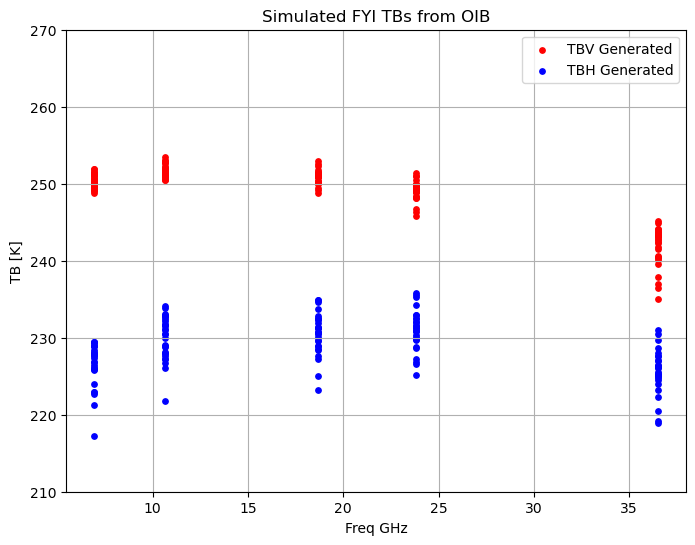

range(3, 40)


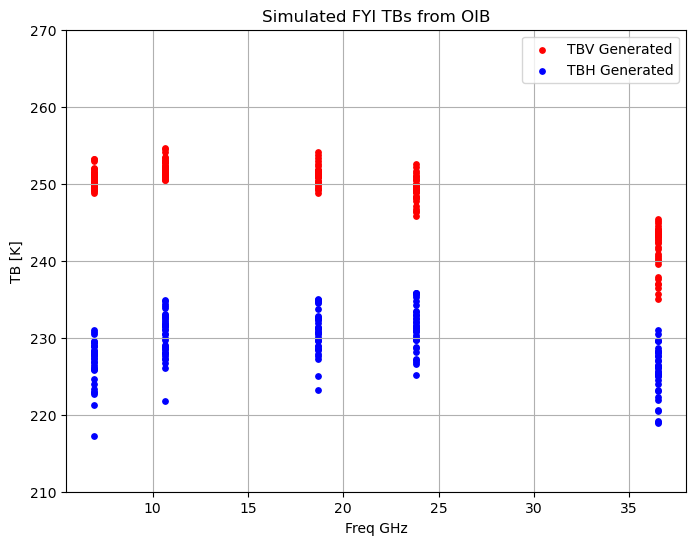

range(4, 50)


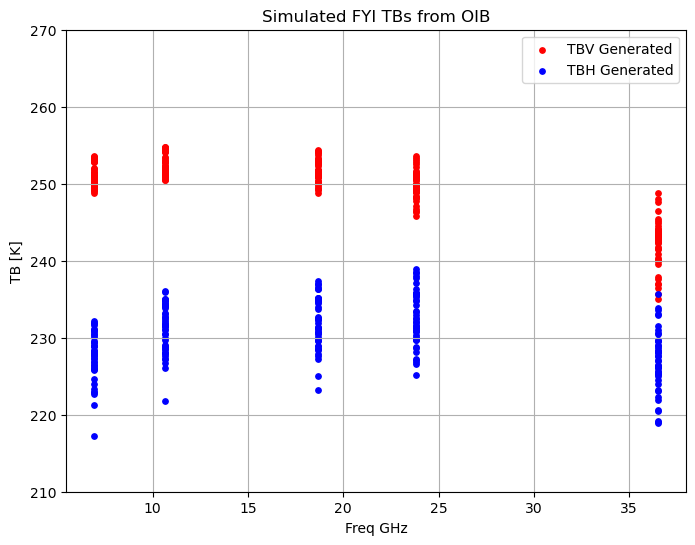

range(5, 60)


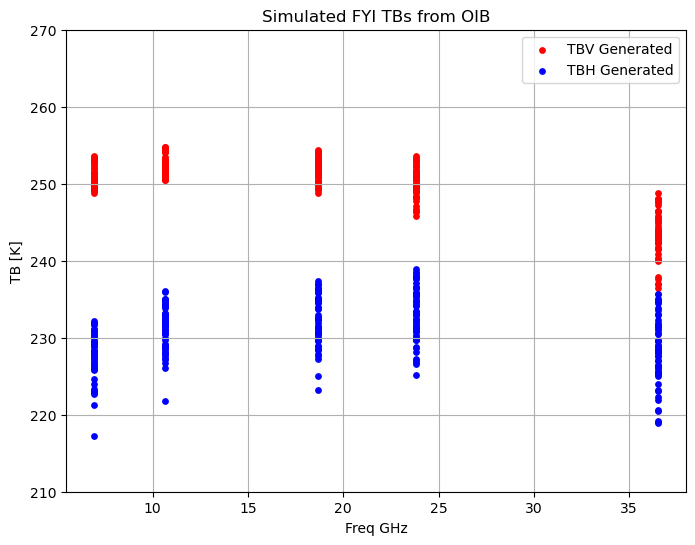

range(6, 70)


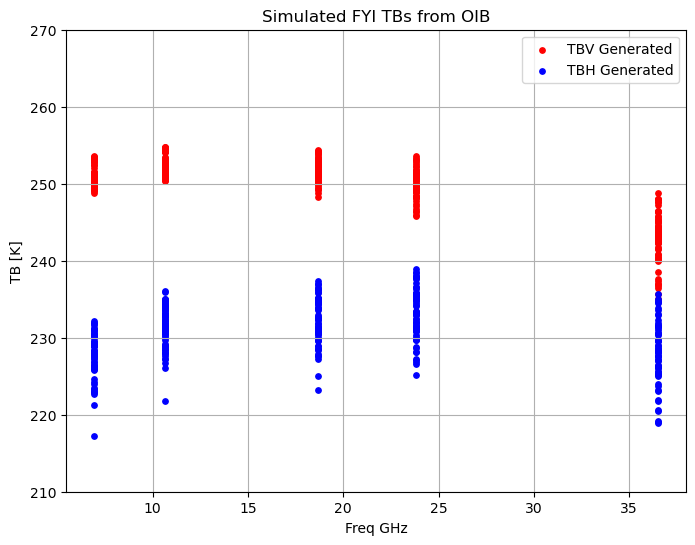

range(7, 80)


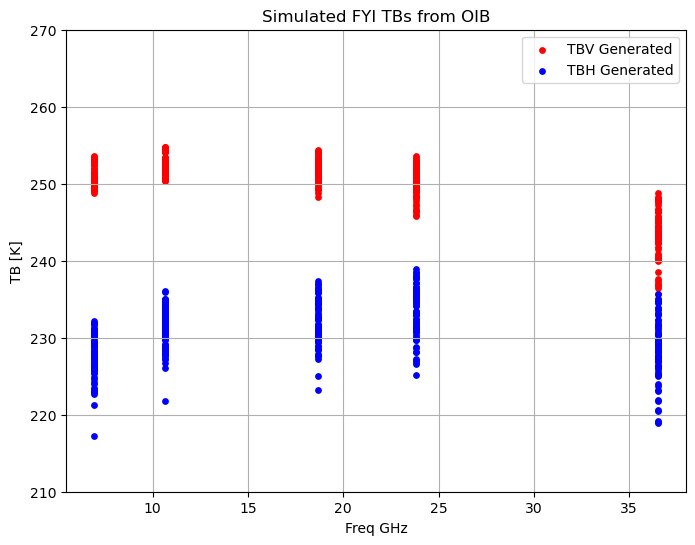

range(8, 90)


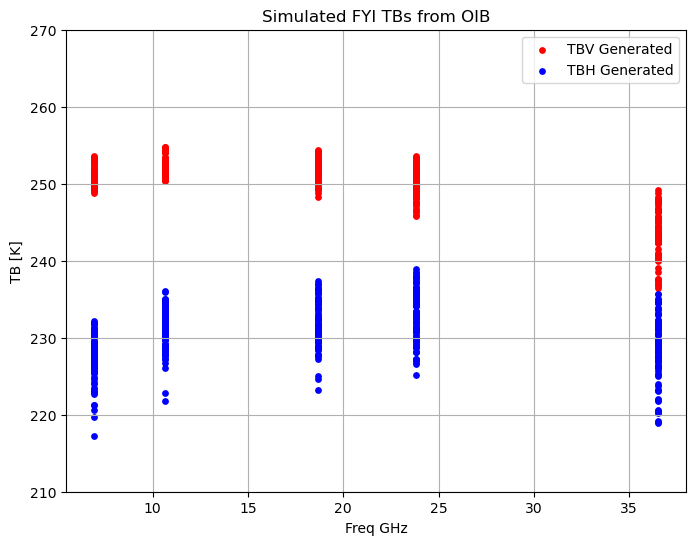

range(9, 100)


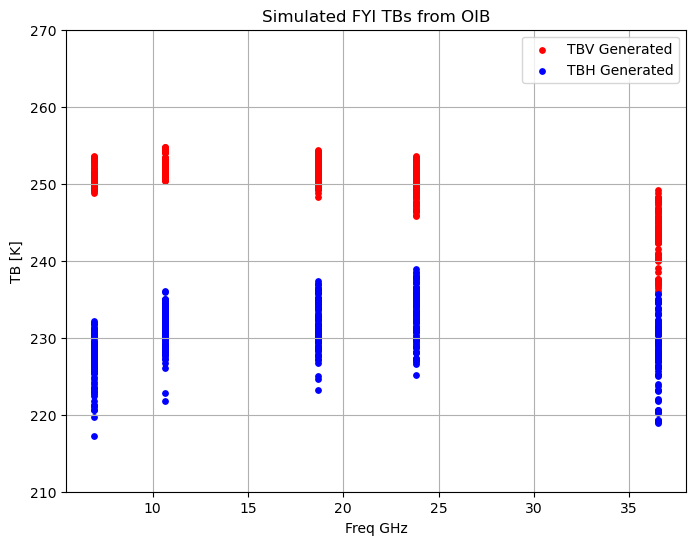

In [18]:
for i in range(1,10):
    nnn = range(1*i,10*(i+1))
    print(nnn)
    plt.figure(figsize=(8,6))
    freqs=[6.925,10.65,18.7,23.8,36.5];
    y = FYI_data.TbV_AMSR_all[nnn]
    plot1 = plt.scatter([freqs]*len(nnn), y, s=15, c='r')
    y = FYI_data.TbH_AMSR_all[nnn]
    plot2 = plt.scatter([freqs]*len(nnn),y, s=15, c='b')
    plt.legend(['TBV Generated', 'TBH Generated'])
    plt.grid()
    plt.ylim([210,270])
    plt.xlabel('Freq GHz')
    plt.ylabel('TB [K]')
    plt.title('Simulated FYI TBs from OIB')
    plt.show()

In [ ]:
results = []
x_optimals = []
ns = 100
nn = [i for i in range(ns)]
no = []

SD_not_converged = []
SIT_not_converged = []

for TbV, TbH, n in zip(FYI_data.TbV_AMSR_all[:ns], FYI_data.TbH_AMSR_all[:ns], range(len(FYI_data.skt[:ns]))):
# for TbV, TbH, n in zip(FYI_data.TbV_sim[:ns], FYI_data.TbH_sim[:ns], range(len(FYI_data.skt[:ns]))):
    forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n":n}
    y_obs = np.concatenate((TbV, TbH))
    # x_ap[2] = Tsur
    oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        )
    try:
        oe.doRetrieval(maxIter=10)
        x_optimals.append(oe.x_op)

        ## Plots results
        # res_start = forward_OIB([], [], nl_snow)
        results.append(oe.y_op)
    except:
        print('Convergence not reached')
        print('Snow depth is: ', np.sum(FYI_data.sd[n]))
        print('SIT is: ', FYI_data.sit[n])
        
        SD_not_converged.append(np.sum(FYI_data.sd[n]))
        SIT_not_converged.append(np.mean(FYI_data.sit[n]))
        nn.remove(n)
        no.append(n)

############################################################
reset due to x_upperLimit: lex from 0.001705 to 0.000500 in iteration 0
############################################################
reset due to x_upperLimit: lex from 0.001182 to 0.000500 in iteration 1
1.52 s, iteration 1, degrees of freedom: 4.01 of 6, not converged (x-space):  79901.596
2.32 s, iteration 2, degrees of freedom: 3.90 of 6, not converged (x-space):  53.278
3.02 s, iteration 3, degrees of freedom: 3.65 of 6, not converged (x-space):  88.763
3.67 s, iteration 4, degrees of freedom: 3.73 of 6, not converged (x-space):  3.024
4.44 s, iteration 5, degrees of freedom: 3.69 of 6, converged (x-space):  0.156
5.16 s, iteration 6, degrees of freedom: 3.73 of 6, done.  0.053


In [ ]:
nnn = np.array(nn, dtype=int)
plt.figure(figsize=(6,6))
x = np.linspace(1, len(SD_not_converged), len(SD_not_converged))
yy = np.sum(FYI_data.sd[nnn], axis=1)
plt.plot(yy)
plt.plot(SD_not_converged)

y = np.linspace(1, len(yy), len(yy))

plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.grid()
plt.show()


In [ ]:
nnn= np.array(nn, dtype=int)
yV = np.mean(FYI_data.TbV_AMSR_all[nnn], axis=0)
yH =  np.mean(FYI_data.TbH_AMSR_all[nnn], axis=0)
x = np.concatenate([freqs]) # *len(nnn)

noo = np.array(no, dtype=int)
yV_no = np.mean(FYI_data.TbV_AMSR_all[noo], axis=0)
yH_no = np.mean(FYI_data.TbH_AMSR_all[noo], axis=0)
# x_no = [freqs]*len(noo)

plt.figure(figsize=(6,6))
plt.plot(x, yV, label='TBV converged')
plt.plot(x, yH, label='TBH converged')
plt.plot(x, yV_no, label='TBV not converged')
plt.plot(x, yH_no, label='TBH not converged')
plt.ylim([210,270])
plt.xlabel('freq [GHz]')
plt.legend()
plt.ylabel('TB [K]')
plt.title('Converged/not converged TBs')
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(3, figsize=(7,10), sharex=False)

vars = ['SD', 'SIT', 'Tsur']
xlabel = ['m', 'm','K']
xlim = [[0,0.4], [0,3], [240, 260]]
binss = [np.linspace(0, 1, 50), np.linspace(0, 5, 100), np.linspace(230, 270, 50)]
# bins = 
for var, i in zip([np.sum(FYI_data.sd, axis=1), FYI_data.sit, FYI_data.skt], range(3)):
    bins = binss[i]
    ax[i].hist(var[nnn], bins=bins, rwidth=0.85, alpha=0.7, label = 'converged')
    ax[i].hist(var[noo], bins=bins, rwidth=0.85, alpha=0.7, label='not converged')
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
plt.legend(bbox_to_anchor=(1.35, 3.5))

In [ ]:
fig, ax = plt.subplots(5, figsize=(8,8), sharex=True)
freqs=[6.9,10.7,18.7,23.8,36.5];
for i in range(5):
    bins = np.linspace(220, 270, 100)
   
    ax[i].hist([TbV[i] for TbV in FYI_data.TbV_AMSR_all[nnn]], bins=bins, rwidth=0.85, alpha=0.6)
    ax[i].hist([TbV[i] for TbV in FYI_data.TbV_AMSR_all[noo]], bins=bins, rwidth=0.85, alpha=0.7)
    
    ax[i].hist([TbH[i] for TbH in FYI_data.TbH_AMSR_all[nnn]], bins=bins, rwidth=0.85, alpha=0.6)
    ax[i].hist([TbH[i]for  TbH in FYI_data.TbH_AMSR_all[noo]], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(freqs[i]) + ' GHz')
    ax[i].set_xlim([215,261])
plt.xlabel('TB [K]')
plt.legend(['TBV converged', 'TBV not converged', 'TBH converged', 'TBH not converged'], bbox_to_anchor=(1.35, 3.5))
# plt.title('Simulated and Generated TBs')

In [ ]:
nnn = np.array(nn, dtype=int)
plt.figure(figsize=(8,6))
freqs=[6.925,10.65,18.7,23.8,36.5];
# FYI_data = piO.OIB_data('FYI')
# FYI_OIB_AMSR = FYI_OIB_AMSR + FYI_bias
y = FYI_data.TbV_AMSR_all[nnn]
plot1 = plt.scatter([freqs]*len(nnn), y, s=15, c='r')
y = FYI_data.TbH_AMSR_all[nnn]
plot2 = plt.scatter([freqs]*len(nnn),y, s=15, c='b')
y = [res[:5] for res in results]
plot3 = plt.scatter([freqs]*len(nnn), y, s=15, c='k')
y = [res[5:] for res in results]
plot4 = plt.scatter([freqs]*len(nnn), y, s=15, c='green')
plt.legend(['TBV Generated', 'TBH Generated', 'TBV SIM OE', 'TBH SIM OE'])
plt.grid()
plt.ylim([210,270])
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(5, figsize=(8,8), sharex=True)
freqs=[6.9,10.7,18.7,23.8,36.5];
for i in range(5):
    bins = np.linspace(220, 270, 100)
    ax[i].hist([res[i] for res in results], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([TbV[i] for TbV in FYI_data.TbV_AMSR_all[nnn]], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([res[i+5]for res in results], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([TbH[i] for TbH in FYI_data.TbH_AMSR_all[nnn]], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(freqs[i]) + ' GHz')
plt.xlabel('TB [K]')
plt.legend(['TBV OE', 'TBV AMSR', 'TBH OE', 'TBH AMSR'], bbox_to_anchor=(1.35, 3.5))
# plt.legend(['TBV OE', 'TBV generated', 'TBH OE', 'TBH generated'], bbox_to_anchor=(1.35, 3.5))
# plt.title('Simulated and Generated TBs')

In [ ]:
# print([x_optim for x_optim in x_optimals])
SD_OE = []
SD_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.sd[nnn]):
    try:
        SD_OE.append([x_optim['SD0'] + x_optim['SD1']])
        SD_OIB.append(np.sum(n))
        
    except:
        print('convergence was not reached at: ', x_optim)
                      
diag = np.linspace(0,400,400)

plt.figure(figsize=(6,6))
plt.scatter(SD_OIB, SD_OE)
plt.plot(diag, diag, 'k')
plt.grid()
plt.title('SD comp OE/OIB')
plt.xlabel('SD OIB')
plt.ylabel('SD OE')
plt.xlim([0.03, 0.3])
plt.ylim([0.03, 0.3])


lex0_OE = []
lex0_OIB = []
lex1_OE = []
lex1_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.sd_lex[nnn]):
    try:
        lex0_OE.append(x_optim['lex0']*1e3)
        lex0_OIB.append(n[0]*1e3)
        lex1_OE.append(x_optim['lex1']*1e3)
        lex1_OIB.append(n[1]*1e3)
        
    except:
        pass
        # print('convergence was not reached at: ', x_optim)

try:
    lex0_OE[0]
    diag = np.linspace(0,400,400)

    plt.figure(figsize=(6,6))
    plt.scatter(lex0_OIB, lex0_OE)
    plt.scatter(lex1_OIB, lex1_OE)
    plt.plot(diag, diag, 'k')
    plt.grid()
    plt.title('lex comp OE/OIB')
    plt.xlabel('lex OIB')
    plt.ylabel('lex OE')
    plt.xlim([0.2, 0.85])
    plt.ylim([0.2, 0.85])
except:
    print('lex not a free variable')

sal0_OE = []
sal0_OIB = []
sal1_OE = []
sal1_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.sd_sal[nnn]):
    try:
        sal0_OE.append(x_optim['sal0']*1e3)
        sal0_OIB.append(n[0]*1e3)
        sal1_OE.append(x_optim['sal1']*1e3)
        sal1_OIB.append(n[1]*1e3)
        
    except:
        pass
        # print('convergence was not reached at: ', x_optim)
try:
    # sal0_OE[0]
    diag = np.linspace(0,400,400)

    plt.figure(figsize=(6,6))
    plt.scatter(sal0_OIB, sal0_OE)
    plt.scatter(sal1_OIB, sal1_OE)
    plt.plot(diag, diag, 'k')
    plt.grid()
    plt.title('sal comp OE/OIB')
    plt.xlabel('sal OIB')
    plt.ylabel('sal OE')
    plt.xlim([0.1, 12])
    plt.ylim([0.1, 12])
except:
    print('sal not a free variable')


SIT_OE = []
SIT_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.sit[nnn]):
    try:
        SIT_OE.append(x_optim['SIT'])
        SIT_OIB.append(n)
        
    except:
        # print('convergence was not reached at: ', x_optim)
        pass
try:
    #SIT_OE = [x_optim['SIT'] for x_optim in x_optimals]
    #SIT_OIB = FYI_data.sit[:ns]

    plt.figure(figsize=(6,6))
    plt.scatter(SIT_OIB, SIT_OE)
    plt.plot(diag, diag, 'k')
    plt.grid()
    plt.title('SIT comp OE/OIB')
    plt.xlabel('SIT OIB')
    plt.ylabel('SIT OE')
    plt.xlim([0.5, 2.5])
    plt.ylim([0.5, 2.5])
except:
    print('SIT not a free variable')

# Tsnow_OE = [x_optim['Tsur'] for x_optim in x_optimals]
# Tsnow_OIB = FYI_data.skt[:ns]

Tsnow_OE = []
Tsnow_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.skt[nnn]):
    try:
        Tsnow_OE.append(x_optim['Tsur'])
        Tsnow_OIB.append(n)
    except:
        pass
        # print('convergence was not reached at: ', x_optim)
try:
    # T_snow_OE[0]
    plt.figure(figsize=(6,6))
    plt.scatter(Tsnow_OIB, Tsnow_OE)
    plt.plot(diag, diag, 'k')
    plt.grid()
    plt.title('Tsur comp OE/OIB')
    plt.xlabel('Tsur OIB')
    plt.ylabel('Tsur OE')
    plt.xlim([240, 265])
    plt.ylim([240, 265])
except:
    pass
        
m_OE = []
m_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.OIB_surf_rough[nnn]):
    try:
        m_OE.append(x_optim['slope'])
        m_OIB.append(n)
        
    except:
        pass
        #print('convergence was not reached at: ', x_optim)
try:
    # m_OE[0]
    plt.figure(figsize=(6,6))
    plt.scatter(m_OIB, m_OE)
    plt.plot(diag, diag, 'k')
    plt.grid()
    plt.title('Roughness comp OE/OIB')
    plt.xlabel('Surface roughness OIB')
    plt.ylabel('slope OE')
    plt.xlim([0.0, 0.2])
    plt.ylim([0.0, 0.2])
except:
    pass

In [ ]:
#def corrMat(data):
corrMat = np.zeros(oe.S_op.shape)
sigmas = np.diag(oe.S_op)**(1/2)
rows = range(oe.S_op.shape[0])
cols = range(oe.S_op.shape[1])
for row in rows:
    sigma1 = sigmas[row]
    for col in cols:
        sigma2 = sigmas[col]
        
        corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)

        
        
 

    #return corr_mat

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    corrMat,
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance'}
)
ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')

# 

In [ ]:
for d in range(len(np.diag(oe.S_op))):
    oe.S_op[d][d] = oe.S_op[d][d]**(1/2)
oe.S_op['lex0']['lex0'] = oe.S_op['lex0']['lex0']*1e1
oe.S_op['lex1']['lex1'] = oe.S_op['lex1']['lex1']*1e1
try:
    oe.S_op['sal0']['sal0'] = oe.S_op['sal0']['sal0']*1e1
    oe.S_op['sal1']['sal1'] = oe.S_op['sal1']['sal1']*1e1
except:
    pass
try:
    oe.S_op['Tsur']['Tsur'] = oe.S_op['Tsur']['Tsur']/1e2
except:
    pass
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    oe.S_op*1e2,
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [cm,cm,mm,mm,PSU,PSU,cm]'}
)
ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')